# CosmoDC

### Goals
- How to interface QP and sacc
- How to create n(z) uncertainties from an ensemble of n(z)'s

### Requirements
- **A sacc file**: we will use the sacc file of Prat et al 2022 (2212.09345). This sacc file contains the summary statistics measured from the CosmoDC2 simulations using the DESC TXPipe pipeline. The summary statistics include the angular power spectra of the shear-shear, position-shear, and position-position correlations, as well as the cross-correlations between the different probes. The sacc file also contains the redshift distributions of the galaxies in the simulations. For more details see Prat et al 2022. The data can found in NERSC at '/global/cfs/cdirs/lsst/groups/WL/projects/star-challenge/gaussian/data_vectors'.

- **A series of QP ensenbles**: For this tutorials I have created a series of QP ensembles using the cosmoDC2_v1.1.4_image_with_photoz_v1 simulations. This catalog contains photometric redshifts that were computed with the `BPZ` template-based code (https://ui.adsabs.harvard.edu/abs/2000ApJ...536..571B/abstract) by Sam Schmidt. We use all the available pixels and impose a 24.1 magnitude cut in the i-band following Prat et al. The edges of the tomographic bins are also taken from Prat et al.

### Special Dependencies
- **sacc**: standard DESC library to load and save data.
- **rail.rail_prior**: this very own library, used to compute n(z) uncertainties from n(z) ensembles.
- **PACC** is a plotting library (https://github.com/JaimeRZP/pacc) for sacc files.

In [1]:
import numpy as np
from numpy.linalg import cholesky
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.stats as stats
import qp
import sacc
import yaml

import rail.rail_prior as rail_prior
import pacc

### Load Data

In [2]:
# Sacc file
s = sacc.Sacc.load_fits("/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/summary_statistics_fourier_tjpcov.sacc")
y = yaml.load(open("/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/gcgc_gcwl_wlwl.yml"), Loader=yaml.FullLoader)

# Ensembles
source_0 = np.load('/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/nzs/source_0.npz', allow_pickle=True)
source_1 = np.load('/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/nzs/source_1.npz', allow_pickle=True)
source_2 = np.load('/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/nzs/source_2.npz', allow_pickle=True)
source_3 = np.load('/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/nzs/source_3.npz', allow_pickle=True)
source_4 = np.load('/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/nzs/source_4.npz', allow_pickle=True)

lens_0 = np.load('/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/nzs/lens_0.npz', allow_pickle=True)
lens_1 = np.load('/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/nzs/lens_1.npz', allow_pickle=True)
lens_2 = np.load('/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/nzs/lens_2.npz', allow_pickle=True)
lens_3 = np.load('/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/nzs/lens_3.npz', allow_pickle=True)
lens_4 = np.load('/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/nzs/lens_4.npz', allow_pickle=True)

tomos = {'source_0': source_0,
        'source_1': source_1,
        'source_2': source_2,
        'source_3': source_3,
        'source_4': source_4,
        'lens_0': lens_0,
        'lens_1': lens_1,
        'lens_2': lens_2,
        'lens_3': lens_3,
        'lens_4': lens_4}

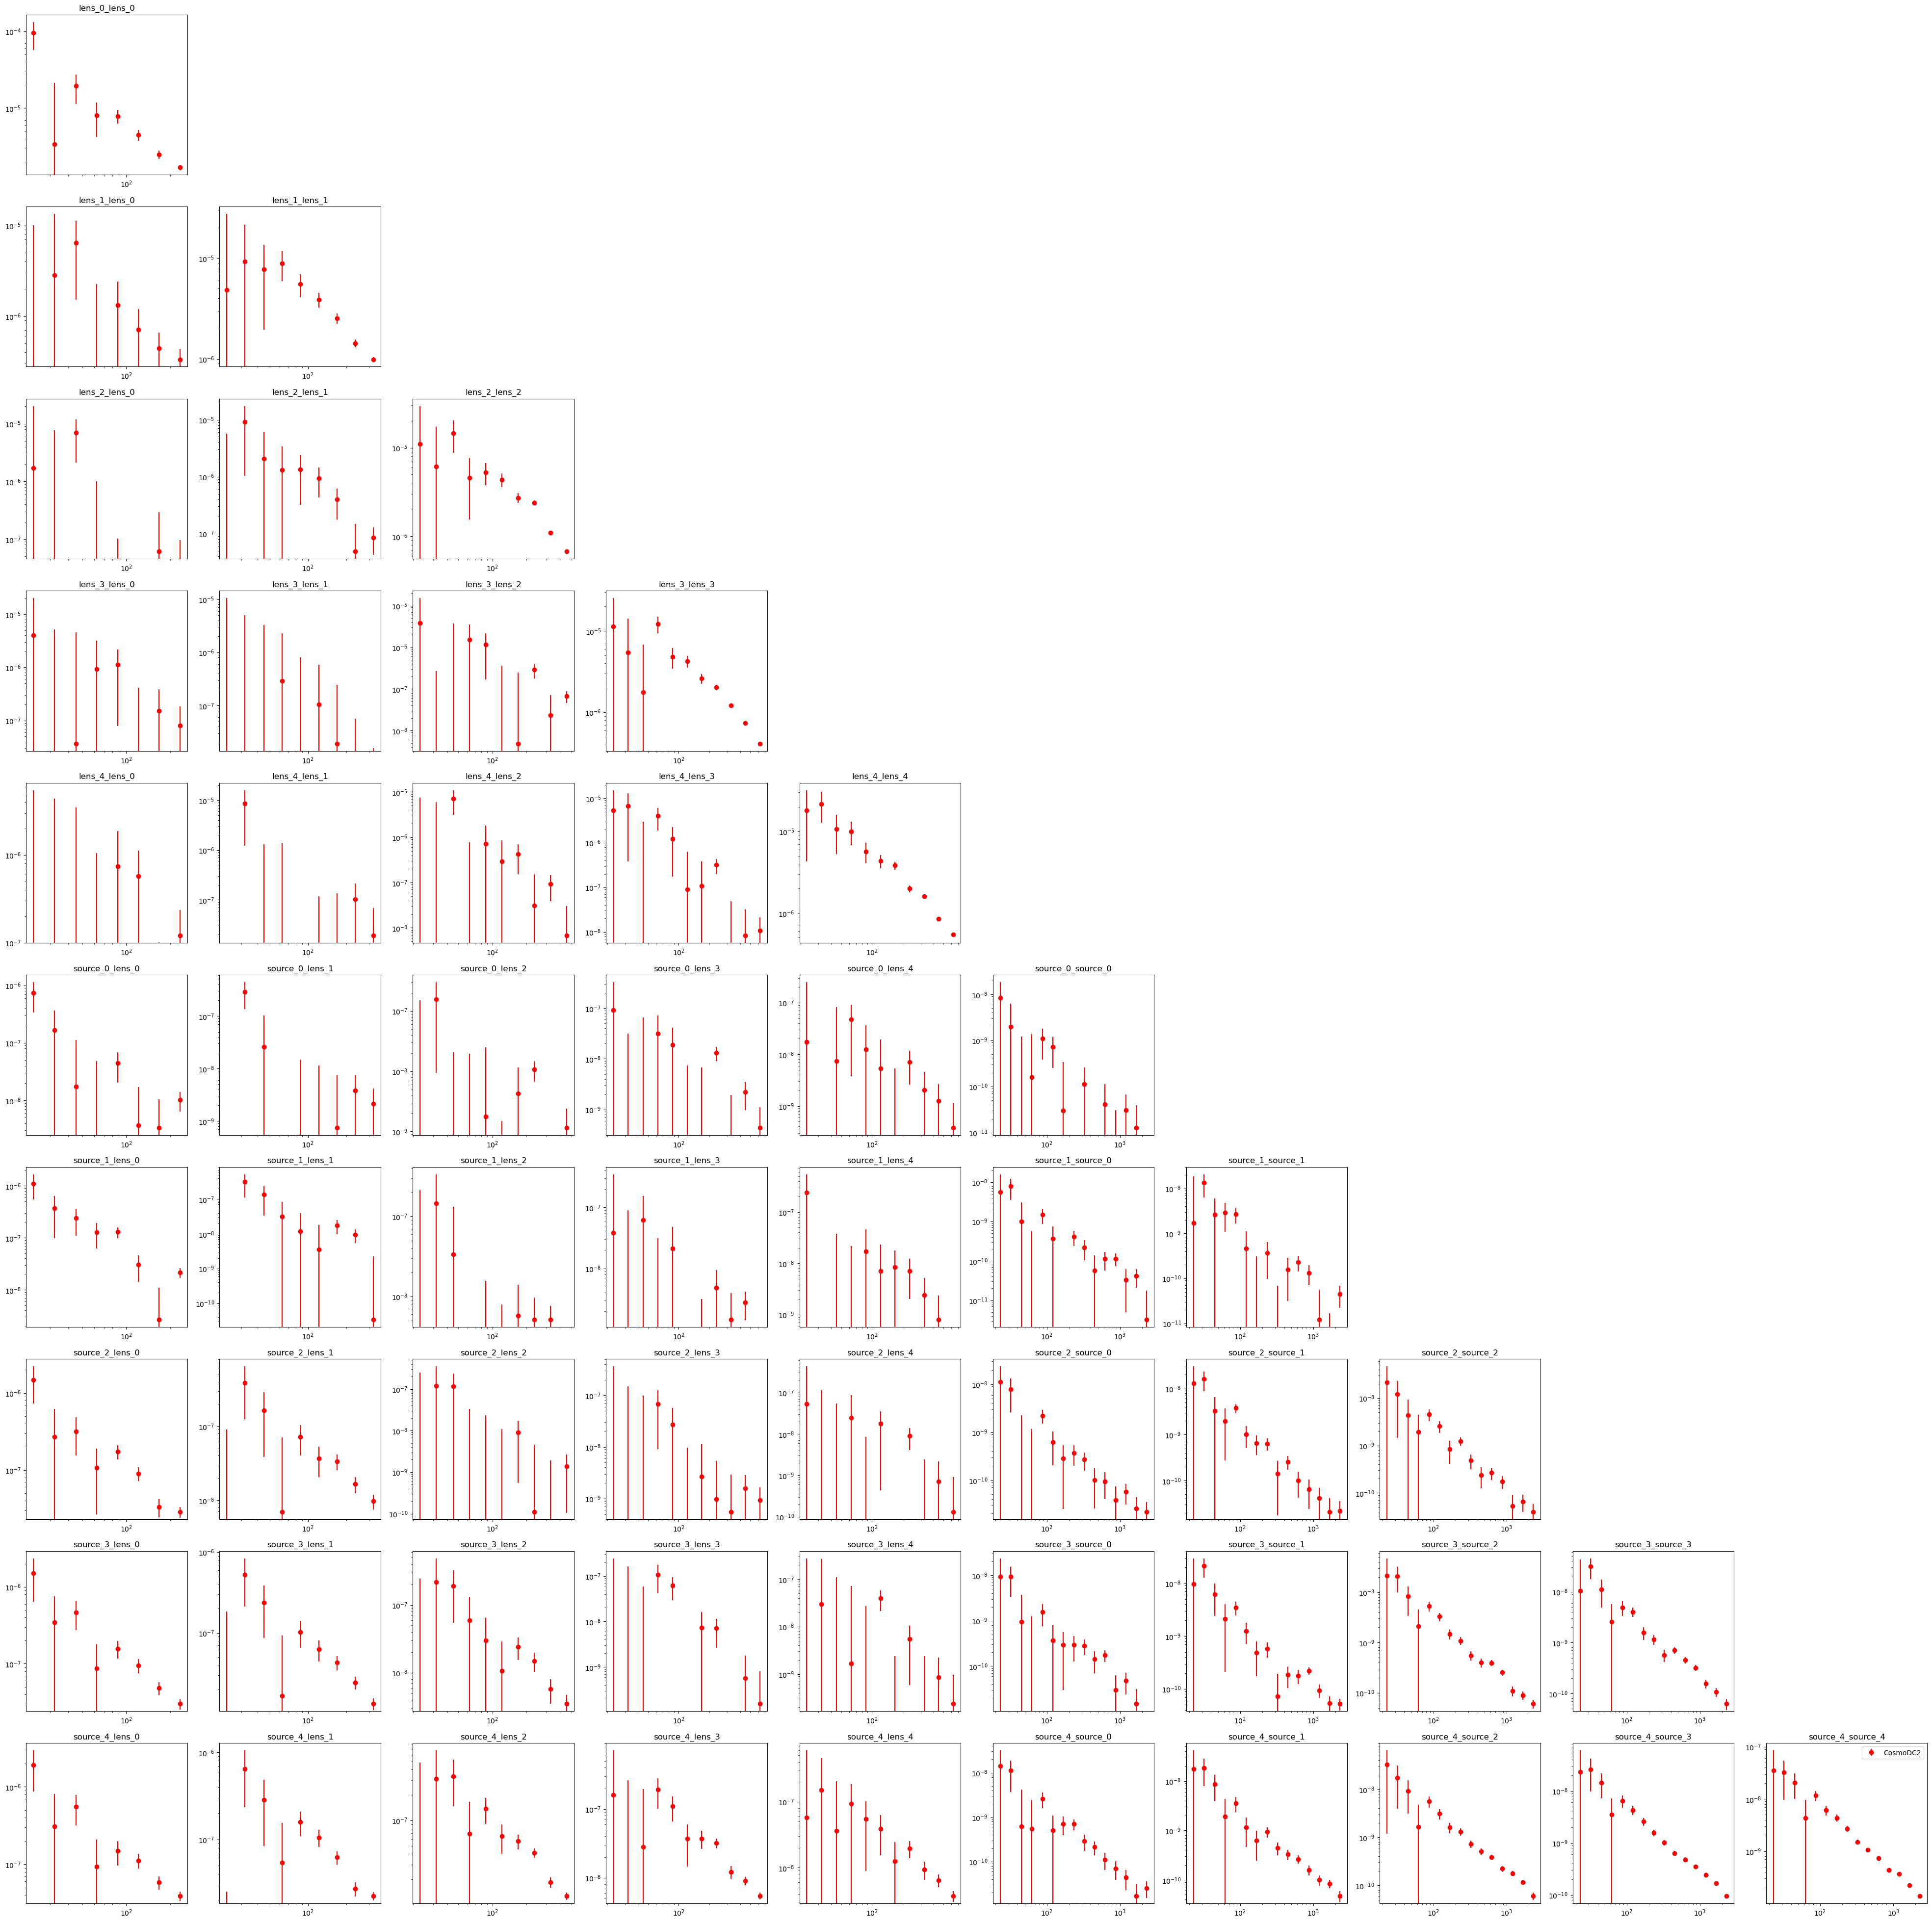

In [3]:
cle = pacc.ClsEnsemble(s, y, label="CosmoDC2")
pacc.plot_cls([cle], cle.pairs)

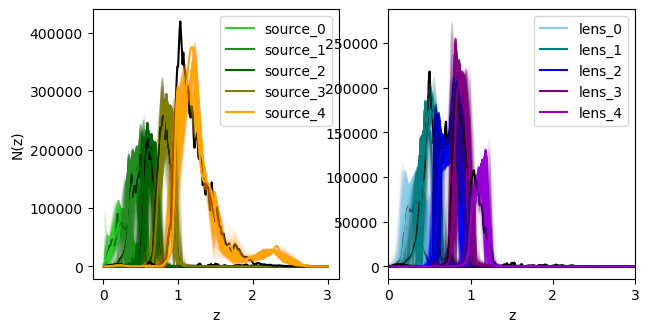

In [4]:
figure, axis = plt.subplots(1, 2, figsize=(7, 3.5))

colors = ['limegreen', 'forestgreen', 'darkgreen', 'olive', 'orange']
lens_keys = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
for i, key in enumerate(lens_keys):
    tomo = tomos[key]
    photo_dz = np.mean(np.diff(tomo['znodes']))
    spec_dz = np.mean(np.diff(tomo['spec_znodes']))
    alpha = photo_dz/spec_dz
    axis[0].plot(tomo['spec_znodes'], alpha*tomo['spec_hist'], 'k-')
    axis[0].plot(tomo['znodes'], tomo['photo_hists'], '-', color=colors[i], alpha=0.01)
    axis[0].plot(tomo['spec_zgrid'], alpha*tomo['photo_fid'], '-', color=colors[i], label=key)
    axis[0].set_xlabel('z')
    axis[0].set_ylabel('N(z)')
    axis[0].legend()

colors = ['skyblue', 'teal', 'blue', 'purple', 'darkviolet']
lens_keys = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
for i, key in enumerate(lens_keys):
    tomo = tomos[key]
    photo_dz = np.mean(np.diff(tomo['znodes']))
    spec_dz = np.mean(np.diff(tomo['spec_znodes']))
    alpha = photo_dz/spec_dz
    axis[1].plot(tomo['spec_znodes'], alpha*tomo['spec_hist'], 'k-')
    axis[1].plot(tomo['znodes'], tomo['photo_hists'], '-', color=colors[i], alpha=0.01)
    axis[1].plot(tomo['spec_zgrid'], alpha*tomo['photo_fid'], '-', color=colors[i], label=key)
    axis[1].set_xlabel('z')
    axis[1].legend()

#nzsum = np.sum(fz_df['pdf'])
#plt.plot(zgrid,nzsum,c='b',label=f"i<{magcut} sum p(z)")

plt.xlim([0.0, 3.0])
plt.show()

In [5]:
def make_nzs_plots(tracers_dict, tracer_list):
    n_tracers = len(tracer_list)
    figure, axis = plt.subplots(2, n_tracers, figsize=(n_tracers*3.5,7))
    figure.subplots_adjust(wspace=0, hspace=0.01)
    for i, key in enumerate(tracer_list):
        tomo = tracers_dict[key]
        nzs = tomo['photo_hists']
        zs = tomo['znodes']
        axis[0,i].plot(zs, nzs, 'k-', alpha=0.01)
        cov = np.cov(nzs)
        nz_mean = np.mean(nzs, axis=1)
        axis[0,i].errorbar(zs, nz_mean, yerr=np.sqrt(np.diag(cov)), fmt='k-')
        axis[0,i].set_xlim([min(zs), max(zs)])
        axis[0,i].set_title(key)
        if i == 0:
            axis[0,i].set_ylabel(r'$p(z)$')
        else:
            axis[0,i].set_yticklabels([])
        im = axis[1,i].imshow(abs(cov), aspect='auto',
                            origin='lower', cmap='gray',
                            extent=[min(zs), max(zs), max(zs), min(zs)])
        axis[1,i].set_xlabel(r'$z$')

    cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
    figure.colorbar(im, cax=cbar_ax)
    plt.show()

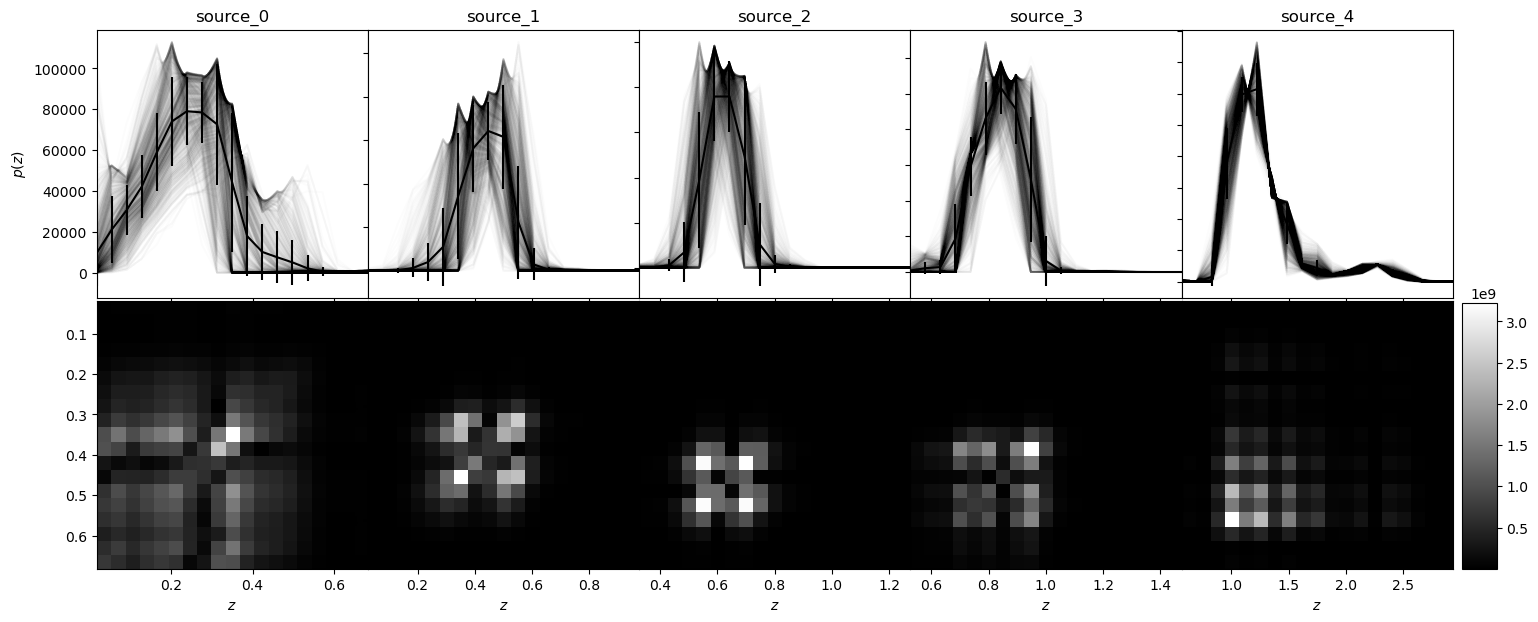

In [6]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(tomos, plot_tracers)

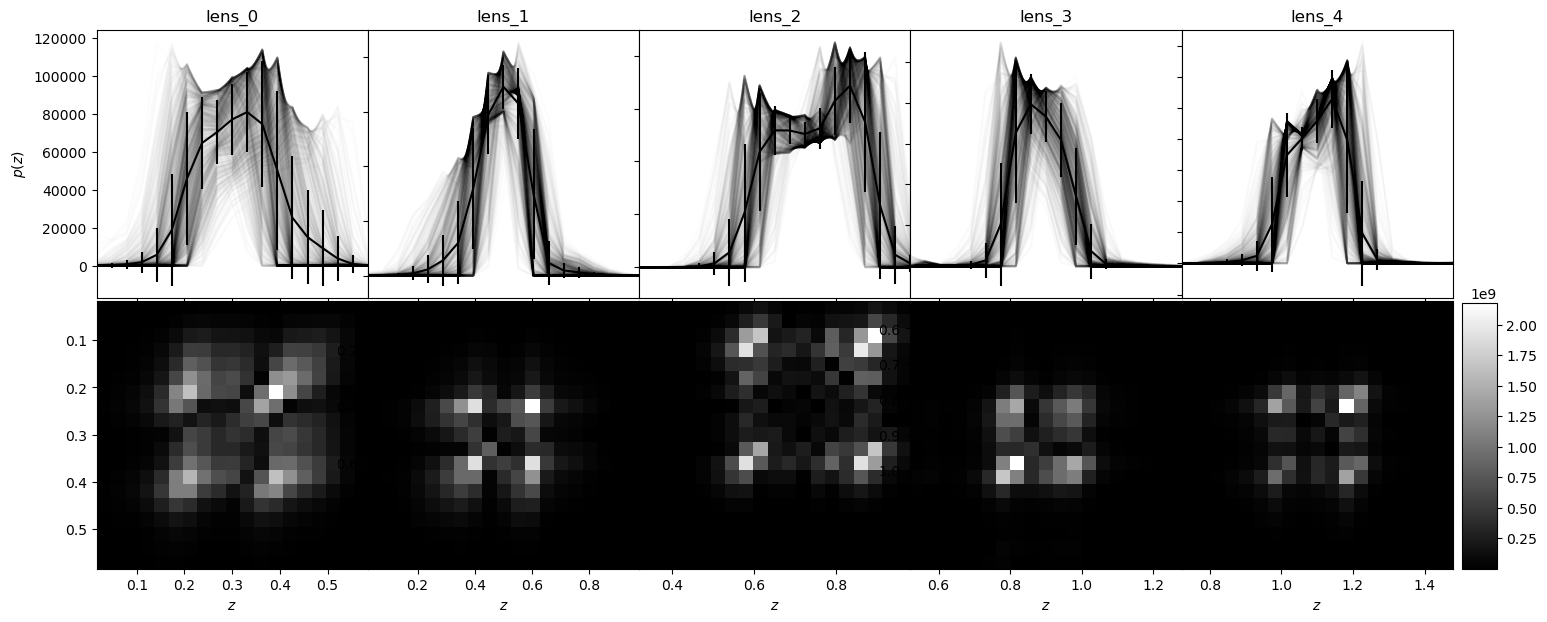

In [7]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(tomos, plot_tracers)

# Interfacing SACC and QP

## Approach 1: No QP

In this approach we will simply use the extra_columns field of the NZTracer tracer in sacc to store the n(z) ensemble as an np.array. This assumes that the qp ensemble is in the histogram format which is what ultimately CCL requires to compute its (non) Limber intergrals.
- **Pros**: 
    - Allows us to use the tradicional NZTrace object which ensures compatiblitly downstream.
    - Doesn't require QP which make the dependencies simpler.
- **Cons**:
    - The user no longer has access to the QP object.

In [8]:
def update_sacc(s, enss):
    ss = s.copy()
    tracers = ss.tracers
    if tracers.keys() != enss.keys():
        raise ValueError("Tracers in sacc file and ensembles do not match")
    for key in tracers.keys():
        t = tracers[key]
        ens = enss[key]
        t.z = ens['znodes']
        t.nz = np.mean(ens['photo_hists'], axis=1)
        t.extra_columns["ensemble"] = ens['photo_hists']
    return ss

ss = update_sacc(s, tomos)

In [9]:
ss.tracers['source_0'].extra_columns

{'ensemble': array([[ 1695,  8728,   369, ..., 13977,  4551,  2446],
        [10106, 31713,  3936, ..., 39422, 21279, 13107],
        [26777, 39749, 15736, ..., 42630, 34922, 29661],
        ...,
        [  294,     5,   554, ...,     0,    18,   203],
        [  373,     2,   714, ...,     0,    26,   193],
        [  382,     3,   911, ...,     0,    22,   168]])}

## Approach 2: QP

In this approach we will make use of the recently developped QPNZTracer object in sacc. This object is a wrapper around the qp ensemble and allows the user to access the ensemble.
- **Pros**: 
    - The user has access to the QP object.
- **Cons**:
    - Requires QP which make the dependencies more complex.
    - Downstream code where NZTRacer was hardcoded will break.

In [10]:
def make_qp(ens):
    pzs = ens['photo_hists'].T
    zs_edges = ens['zgrid']
    return qp.Ensemble(qp.hist, data={"bins":zs_edges, "pdfs":pzs})

def update_sacc_qp(s, enss):
    ss = s.copy()
    tracers = ss.tracers
    if tracers.keys() != enss.keys():
        raise ValueError("Tracers in sacc file and ensembles do not match")
    for key in tracers.keys():
        ens = enss[key]
        q = make_qp(ens)
        ss.add_tracer('Qpnz', key, q)
    return ss

ss_qp = update_sacc_qp(s, tomos)

In [11]:
ss_qp.tracers['source_0'].ensemble

# Computing Uncertainties

Now we are just going to apply the methods of rail_prior described in the basic tutorial for each of the tracers in the sacc file. For the sake of brevity we will only use the qp tracers but the same can be done for the NZTracers.

## Shifts

In [12]:
shifts = {}
for tracer in ss_qp.tracers:
    print(tracer)
    ens = ss_qp.tracers[tracer].ensemble
    shift_obj = rail_prior.PriorShifts(ens)
    shifts[tracer] = shift_obj
    shift = shift_obj.shift
    print(shift)
    
shifts

source_0
[-0.008051893586828998, 0.06856536493871151]
source_1


/home/jaimerz/anaconda3/envs/qp_dev/lib/python3.12/site-packages/rail/rail_prior/prior_shifts.py:49: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  z_m = fsolve(eq, np.mean(self.z))
/home/jaimerz/anaconda3/envs/qp_dev/lib/python3.12/site-packages/rail/rail_prior/prior_shifts.py:49: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  z_m = fsolve(eq, np.mean(self.z))


[0.0075235901026905316, 0.04118247425144592]
source_2
[-0.03926836474208846, 0.07246088550343327]
source_3


/home/jaimerz/anaconda3/envs/qp_dev/lib/python3.12/site-packages/rail/rail_prior/prior_shifts.py:57: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  z_m_fid = fsolve(eq, np.mean(self.z))


[-0.026741579377379598, 0.10089940396625469]
source_4
[0.07872552395518277, 0.24244015452502404]
lens_0
[-0.0861583001431451, 0.08107828555928318]
lens_1
[0.1382027172260965, 0.15074248049027866]
lens_2
[0.15592951239377262, 0.15702254639346191]
lens_3
[0.4360155420121557, 0.08112446672656101]
lens_4
[0.028929207011881414, 0.10212557559276718]


{'source_0': <rail.rail_prior.prior_shifts.PriorShifts at 0x71c3d50baf00>,
 'source_1': <rail.rail_prior.prior_shifts.PriorShifts at 0x71c3c0e68230>,
 'source_2': <rail.rail_prior.prior_shifts.PriorShifts at 0x71c3bdb407d0>,
 'source_3': <rail.rail_prior.prior_shifts.PriorShifts at 0x71c3bfa35d60>,
 'source_4': <rail.rail_prior.prior_shifts.PriorShifts at 0x71c3c0a248f0>,
 'lens_0': <rail.rail_prior.prior_shifts.PriorShifts at 0x71c3be1a26f0>,
 'lens_1': <rail.rail_prior.prior_shifts.PriorShifts at 0x71c3d41bcb90>,
 'lens_2': <rail.rail_prior.prior_shifts.PriorShifts at 0x71c3bed2af60>,
 'lens_3': <rail.rail_prior.prior_shifts.PriorShifts at 0x71c3bf9fa240>,
 'lens_4': <rail.rail_prior.prior_shifts.PriorShifts at 0x71c3c00f4740>}

In [13]:
shifted_nzs = {}
for tracer in ss_qp.tracers:
    print(tracer)
    shift_obj = shifts[tracer]
    pz_fid = [shift_obj.z, shift_obj.nz_mean]
    model = shift_obj.evaluate_model
    shifted_nzs_tracer = np.array([model(pz_fid, shift_obj.sample_prior())[1] for i in range(1000)])
    shifted_nzs[tracer] = [shift_obj.z, shifted_nzs_tracer.T]


source_0
source_1
source_2
source_3
source_4
lens_0
lens_1
lens_2
lens_3
lens_4


In [14]:
def make_nzs_plots(tracers_dict, tracer_list):
    n_tracers = len(tracer_list)
    figure, axis = plt.subplots(2, n_tracers, figsize=(n_tracers*3.5,7))
    figure.subplots_adjust(wspace=0, hspace=0.01)
    for i, key in enumerate(tracer_list):
        zs, nzs = tracers_dict[key]
        axis[0,i].plot(zs, nzs, 'k-', alpha=0.01)
        cov = np.cov(nzs)
        nz_mean = np.mean(nzs, axis=1)
        axis[0,i].errorbar(zs, nz_mean, yerr=np.sqrt(np.diag(cov)), fmt='k-')
        axis[0,i].set_xlim([min(zs), max(zs)])
        axis[0,i].set_title(key)
        axis[0,i].set_ylim([-0.01, 0.35])
        if i == 0:
            axis[0,i].set_ylabel(r'$p(z)$')
        else:
            axis[0,i].set_yticklabels([])
        im = axis[1,i].imshow(abs(cov), aspect='auto',
                            origin='lower', cmap='gray',
                            extent=[min(zs), max(zs), max(zs), min(zs)])
        axis[1,i].set_xlabel(r'$z$')

    cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
    figure.colorbar(im, cax=cbar_ax)
    plt.show()

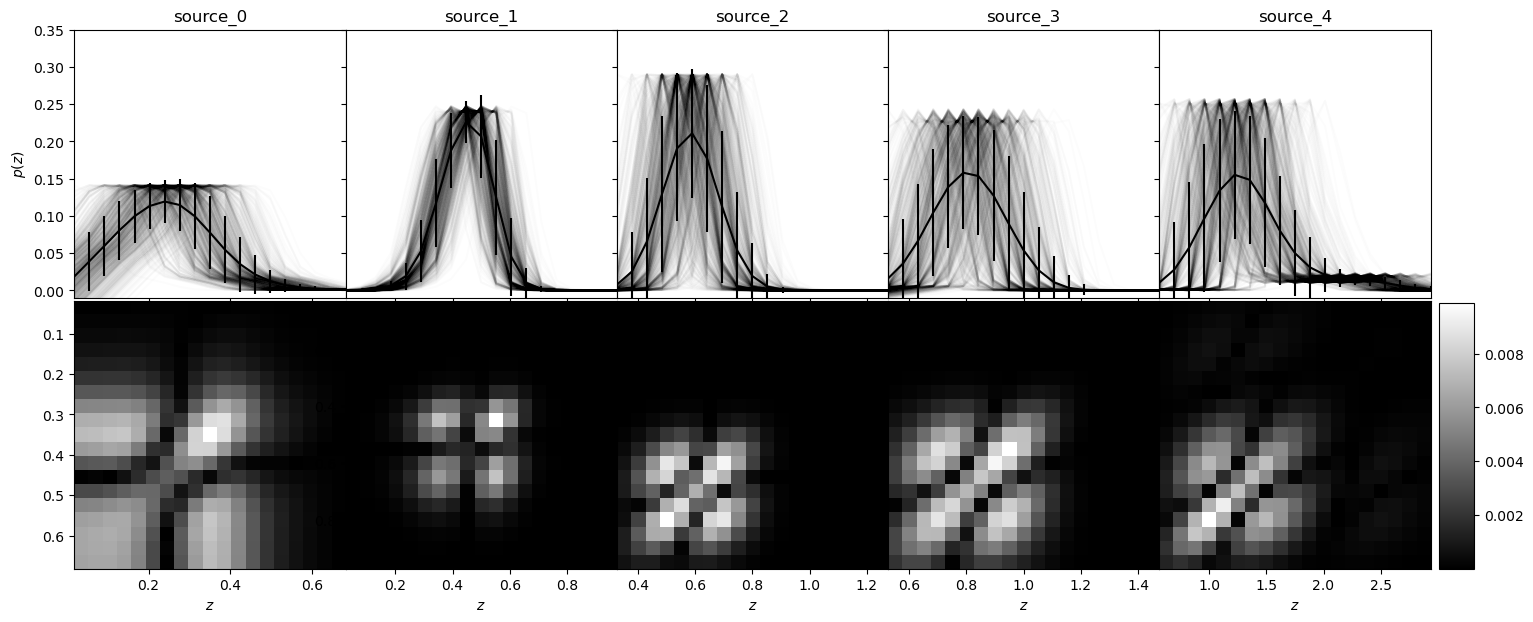

In [15]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(shifted_nzs, plot_tracers)

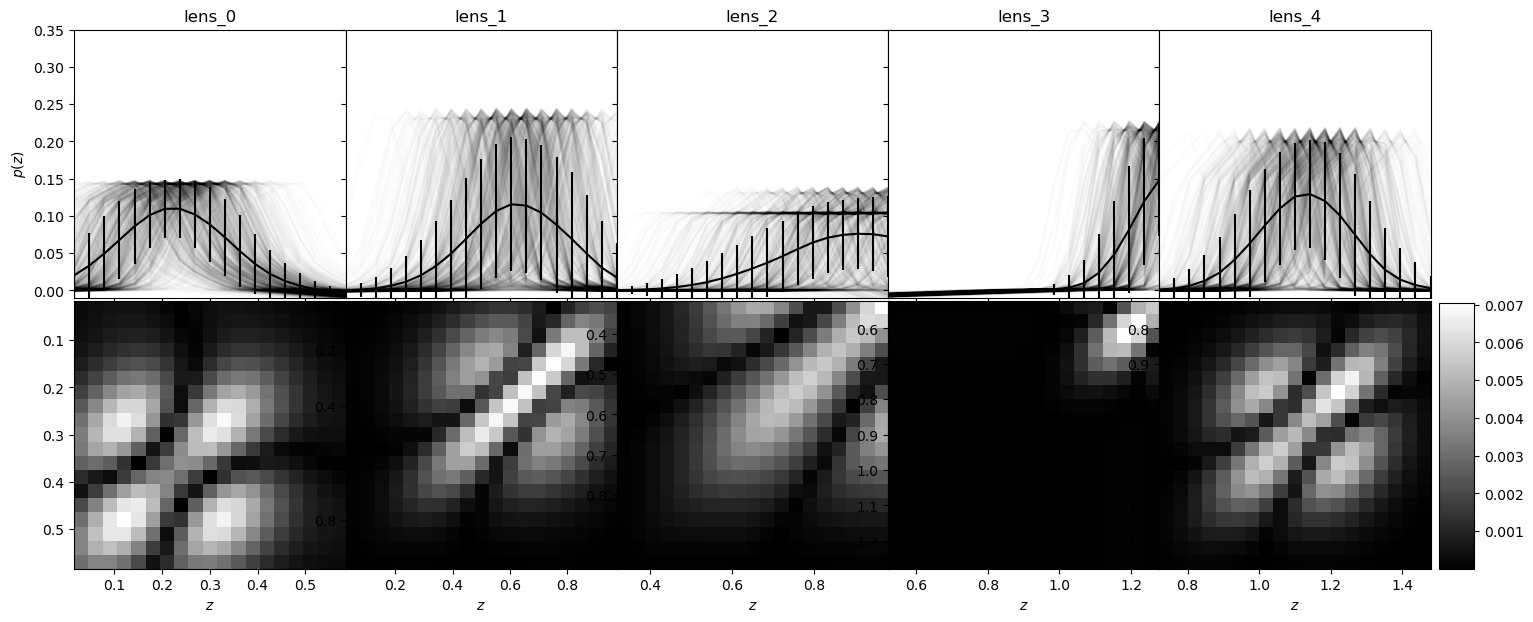

In [16]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(shifted_nzs, plot_tracers)

## Shifts & widths

In [17]:
SnWs = {}
for tracer in ss_qp.tracers:
    print(tracer)
    ens = ss_qp.tracers[tracer].ensemble
    snw_obj = rail_prior.PriorShiftsWidths(ens)
    SnWs[tracer] = snw_obj
SnWs

source_0
source_1
source_2
source_3
source_4
lens_0
lens_1
lens_2
lens_3
lens_4


{'source_0': <rail.rail_prior.prior_shifts_widths.PriorShiftsWidths at 0x71c3c5a87ef0>,
 'source_1': <rail.rail_prior.prior_shifts_widths.PriorShiftsWidths at 0x71c3d4e949b0>,
 'source_2': <rail.rail_prior.prior_shifts_widths.PriorShiftsWidths at 0x71c3d541dd90>,
 'source_3': <rail.rail_prior.prior_shifts_widths.PriorShiftsWidths at 0x71c3d45c6de0>,
 'source_4': <rail.rail_prior.prior_shifts_widths.PriorShiftsWidths at 0x71c3c186daf0>,
 'lens_0': <rail.rail_prior.prior_shifts_widths.PriorShiftsWidths at 0x71c3c186f3b0>,
 'lens_1': <rail.rail_prior.prior_shifts_widths.PriorShiftsWidths at 0x71c3be05eab0>,
 'lens_2': <rail.rail_prior.prior_shifts_widths.PriorShiftsWidths at 0x71c3bf990ce0>,
 'lens_3': <rail.rail_prior.prior_shifts_widths.PriorShiftsWidths at 0x71c3c1af0860>,
 'lens_4': <rail.rail_prior.prior_shifts_widths.PriorShiftsWidths at 0x71c3d466a8a0>}

In [18]:
snw_nzs = {}
for tracer in ss_qp.tracers:
    print(tracer)
    snw_obj = SnWs[tracer]
    pz_fid = [snw_obj.z, snw_obj.nz_mean]
    model = snw_obj.evaluate_model
    snw_nzs_tracer = np.array([model(pz_fid, snw_obj.sample_prior())[1] for i in range(1000)])
    snw_nzs[tracer] = [snw_obj.z, snw_nzs_tracer.T]


source_0
source_1
source_2
source_3
source_4
lens_0
lens_1
lens_2
lens_3
lens_4


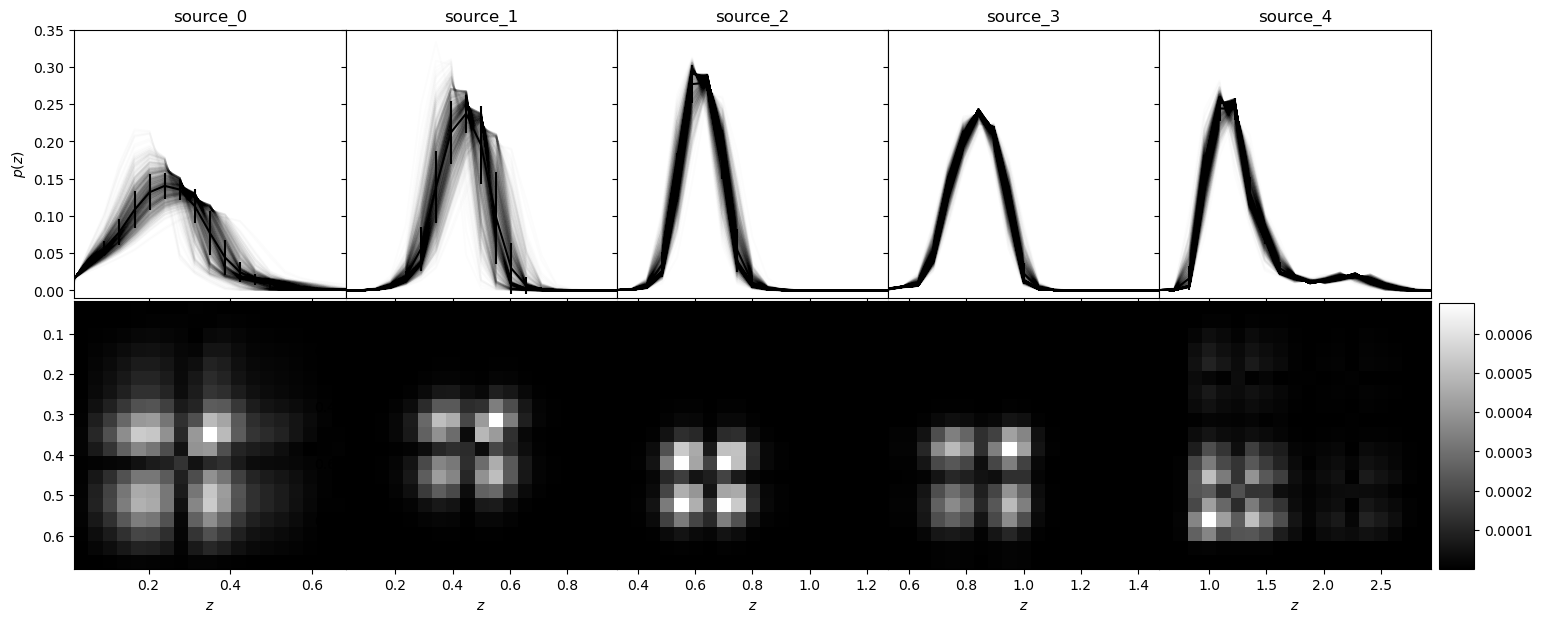

In [19]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(snw_nzs, plot_tracers)

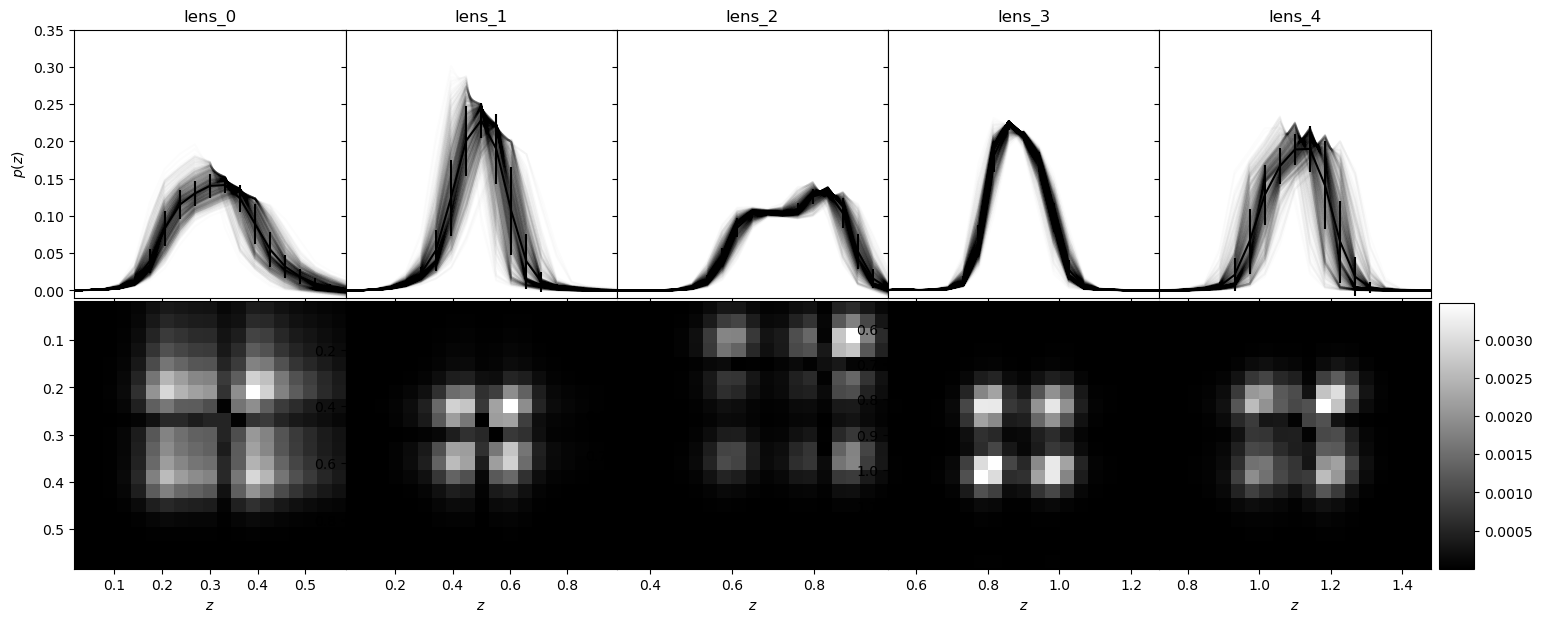

In [20]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(snw_nzs, plot_tracers)

## Moments

In [21]:
moments = {}
for tracer in ss_qp.tracers:
    print(tracer)
    ens = ss_qp.tracers[tracer].ensemble
    moment_obj = rail_prior.PriorMoments(ens)
    moments[tracer] = moment_obj
moments

source_0
source_1
source_2
source_3
source_4
The covariance matrix will be regularized
lens_0
lens_1
lens_2
lens_3
The covariance matrix will be regularized
lens_4
The covariance matrix will be regularized


{'source_0': <rail.rail_prior.prior_moments.PriorMoments at 0x71c3bfd13080>,
 'source_1': <rail.rail_prior.prior_moments.PriorMoments at 0x71c3c48d7620>,
 'source_2': <rail.rail_prior.prior_moments.PriorMoments at 0x71c3d53b3410>,
 'source_3': <rail.rail_prior.prior_moments.PriorMoments at 0x71c3c5ac9670>,
 'source_4': <rail.rail_prior.prior_moments.PriorMoments at 0x71c3c55035f0>,
 'lens_0': <rail.rail_prior.prior_moments.PriorMoments at 0x71c3c4ab0ce0>,
 'lens_1': <rail.rail_prior.prior_moments.PriorMoments at 0x71c3d5257f80>,
 'lens_2': <rail.rail_prior.prior_moments.PriorMoments at 0x71c3c1c81610>,
 'lens_3': <rail.rail_prior.prior_moments.PriorMoments at 0x71c3d4991af0>,
 'lens_4': <rail.rail_prior.prior_moments.PriorMoments at 0x71c3d420b5f0>}

In [22]:
moments_nzs = {}
for tracer in ss_qp.tracers:
    print(tracer)
    moments_obj = moments[tracer]
    pz_fid = [moments_obj.z, moments_obj.nz_mean]
    model = moments_obj.evaluate_model
    moments_nzs_tracer = np.array([model(pz_fid, moments_obj.sample_prior())[1] for i in range(1000)])
    moments_nzs[tracer] = [moments_obj.z, moments_nzs_tracer.T]

source_0
source_1
source_2
source_3
source_4
lens_0
lens_1
lens_2
lens_3
lens_4


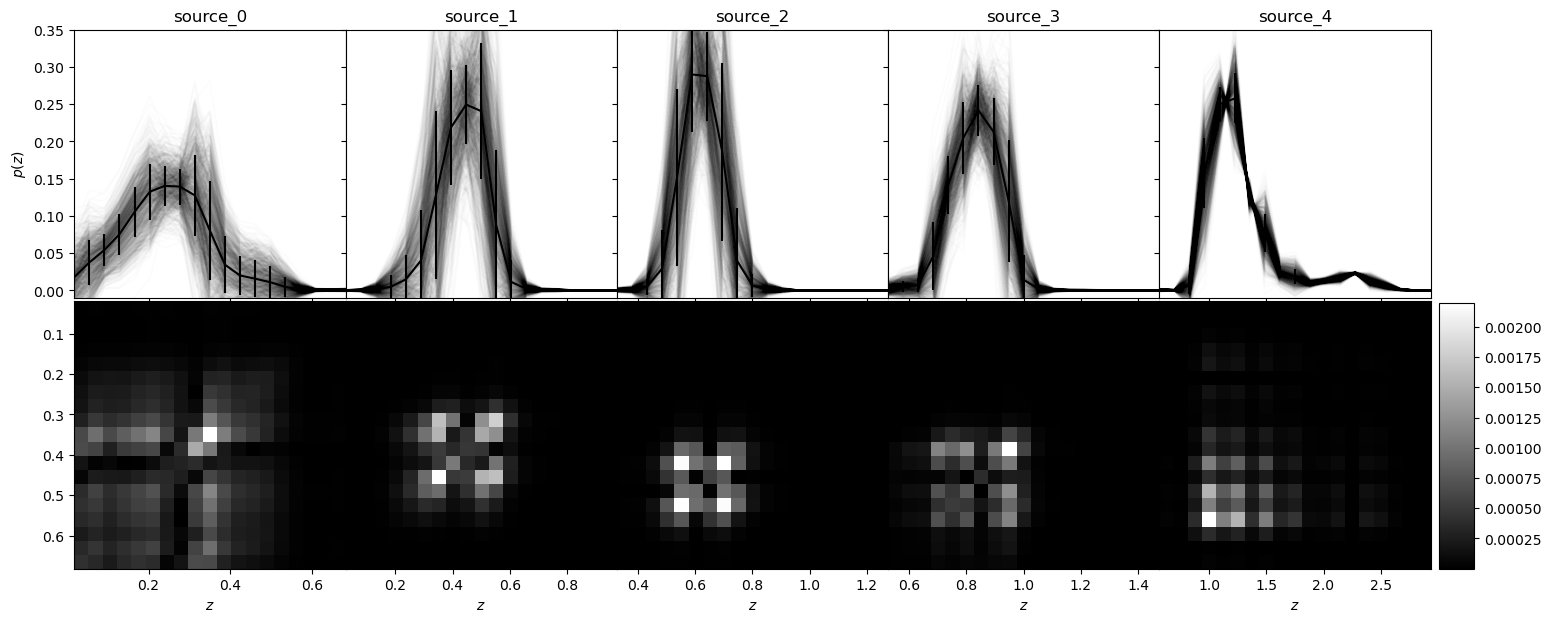

In [23]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(moments_nzs, plot_tracers)

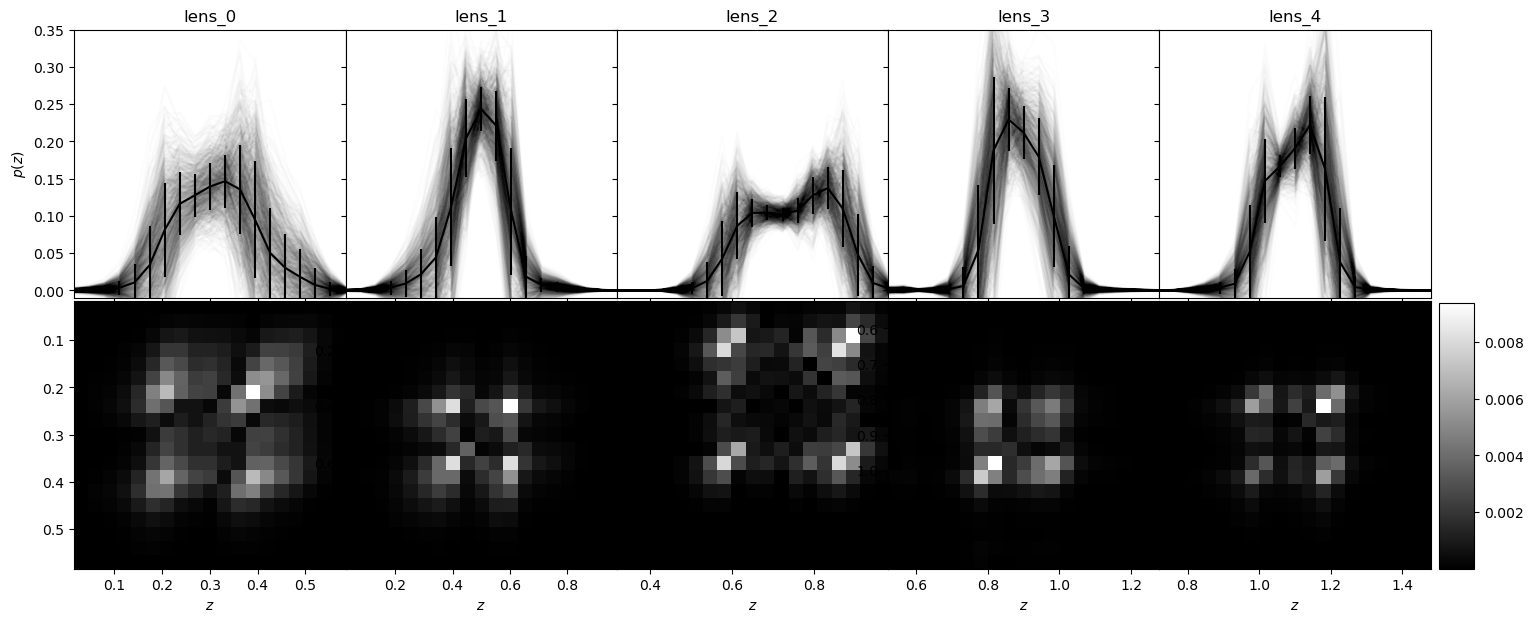

In [24]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(moments_nzs, plot_tracers)